# Pipeline Principal: Fusión de Imágenes y Medición

Este notebook implementa el pipeline completo para fusionar las tres imágenes del comedor en un panorama coherente, calibrar el sistema y realizar mediciones.

## Objetivos

1. Cargar las tres imágenes originales
2. Detectar características y establecer correspondencias
3. Estimar homografías robustas con RANSAC
4. Fusionar imágenes con técnicas de blending
5. Calibrar el sistema usando objetos de referencia
6. Medir dimensiones de elementos en la escena
7. Analizar incertidumbre en las mediciones


In [21]:
# Importar librerías
import sys
sys.path.append('..')

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd

# Importar módulos propios
from src import utils
from src.feature_detection import FeatureDetector, DetectorType
from src.matching import FeatureMatcher, MatcherType, get_matched_points
from src.registration import ImageStitcher, estimate_homography, warp_image
from src.measurement import Calibrator, InteractiveMeasurementTool, measure_distance_simple

# Configuración
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10
np.set_printoptions(precision=4, suppress=True)

print("Librerías importadas correctamente")


Librerías importadas correctamente


## 1. Cargar Imágenes del Comedor

Cargamos las tres imágenes originales del comedor.


Imágenes encontradas: 3
  IMG01.jpg: (4032, 3024, 3)
  IMG02.jpg: (4032, 3024, 3)
  IMG03.jpg: (3024, 4032, 3)


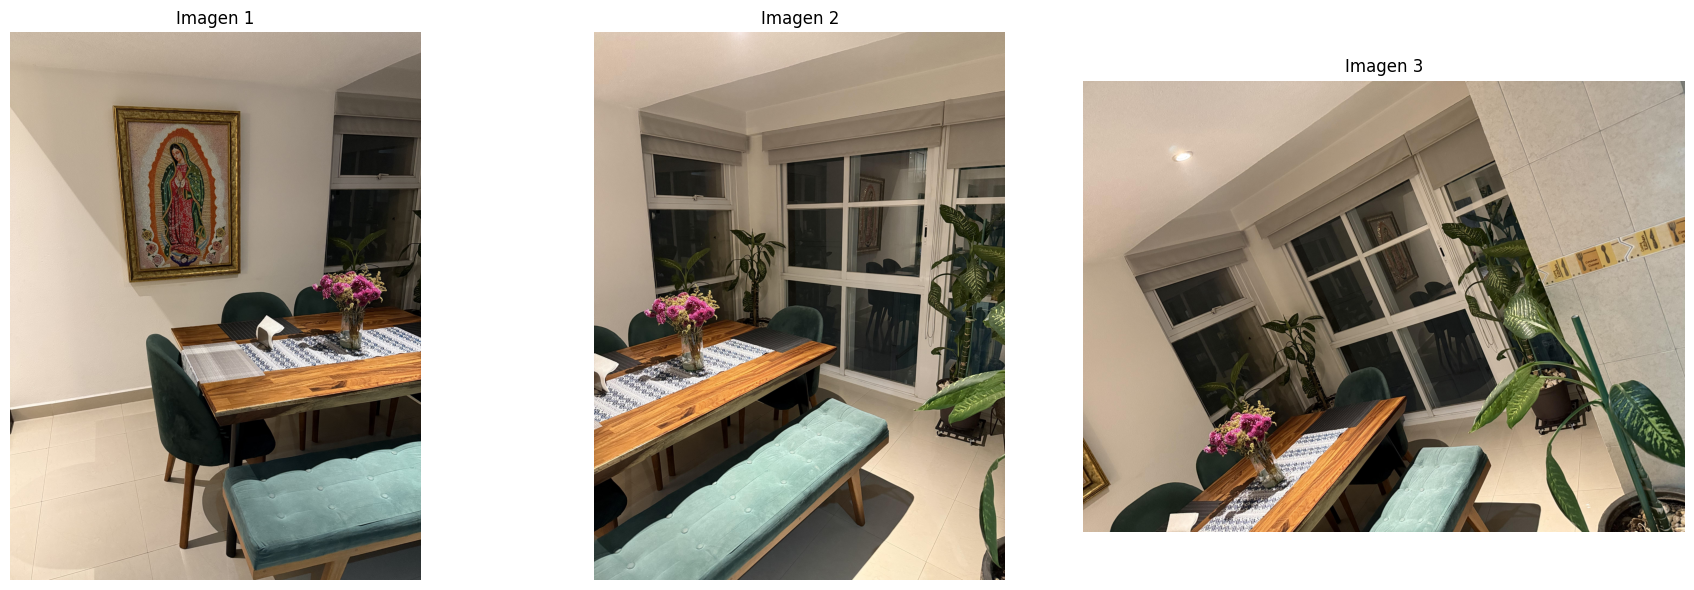

In [22]:
# Cargar imágenes
image_dir = Path('../data/original')
image_paths = sorted(list(image_dir.glob('*.jpg')))

print(f"Imágenes encontradas: {len(image_paths)}")

images = []
for path in image_paths:
    img = utils.load_image(str(path))
    images.append(img)
    print(f"  {path.name}: {img.shape}")

# Visualizar
utils.visualize_images(
    images,
    titles=[f'Imagen {i+1}' for i in range(len(images))],
    figsize=(18, 6)
)


## 2. Detección de Características

Detectamos características en todas las imágenes usando SIFT.


In [23]:
# Usar SIFT como detector principal
detector = FeatureDetector(DetectorType.SIFT)

print("Detectando características...")
all_keypoints = []
all_descriptors = []

for i, img in enumerate(images):
    kp, desc = detector.detect_and_compute(img)
    all_keypoints.append(kp)
    all_descriptors.append(desc)
    print(f"  Imagen {i+1}: {len(kp)} keypoints")


Detectando características...
  Imagen 1: 61930 keypoints
  Imagen 2: 37273 keypoints
  Imagen 3: 33332 keypoints


## 3. Emparejamiento de Características

Establecemos correspondencias entre imágenes consecutivas.


In [24]:
# Matcher
matcher = FeatureMatcher(MatcherType.BF, descriptor_type='SIFT')

print("Emparejando características...")
matches_data = []

for i in range(len(images) - 1):
    print(f"\n  Par {i+1}-{i+2}:")
    
    # Match robusto
    matches = matcher.match_robust(all_descriptors[i], all_descriptors[i+1], ratio=0.75)
    points1, points2 = get_matched_points(all_keypoints[i], all_keypoints[i+1], matches)
    
    print(f"    Matches: {len(matches)}")
    print(f"    Puntos extraídos: {len(points1)}")
    
    matches_data.append({
        'matches': matches,
        'points1': points1,
        'points2': points2
    })


Emparejando características...

  Par 1-2:
    Matches: 5795
    Puntos extraídos: 5795

  Par 2-3:
    Matches: 6129
    Puntos extraídos: 6129


## 4. Fusión de Imágenes (Stitching)

Usamos ImageStitcher para fusionar las imágenes en un panorama coherente.


In [25]:
# Crear stitcher con blending feather (transiciones suaves)
stitcher = ImageStitcher(blend_method='feather')

# Estimar transformaciones
print("Estimando homografías...")
reference_idx = 1  # Usar imagen central como referencia

success = stitcher.estimate_transforms(images, matches_data, reference_idx=reference_idx)

if success:
    print(" Homografías estimadas correctamente")
    
    # Mostrar homografías
    for i, H in enumerate(stitcher.homographies):
        if H is not None:
            print(f"\nHomografía imagen {i} a referencia:")
            print(H)
else:
    print(" Error al estimar homografías")
    raise Exception("No se pudieron estimar las homografías")


Estimando homografías...
 Homografías estimadas correctamente

Homografía imagen 0 a referencia:
[[    2.0014     0.2046 -4181.902 ]
 [    0.4856     1.7448  -870.0696]
 [    0.0004    -0.0001     1.    ]]

Homografía imagen 1 a referencia:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Homografía imagen 2 a referencia:
[[   0.8459   -0.3042  380.124 ]
 [   0.3218    0.7565 -267.1102]
 [  -0.       -0.        1.    ]]



Fusionando imágenes...
Tamaño del panorama: 8642x8928
Procesando imagen 1/3...
Procesando imagen 2/3...
Procesando imagen 3/3...
 Panorama creado: (8928, 8642, 3)


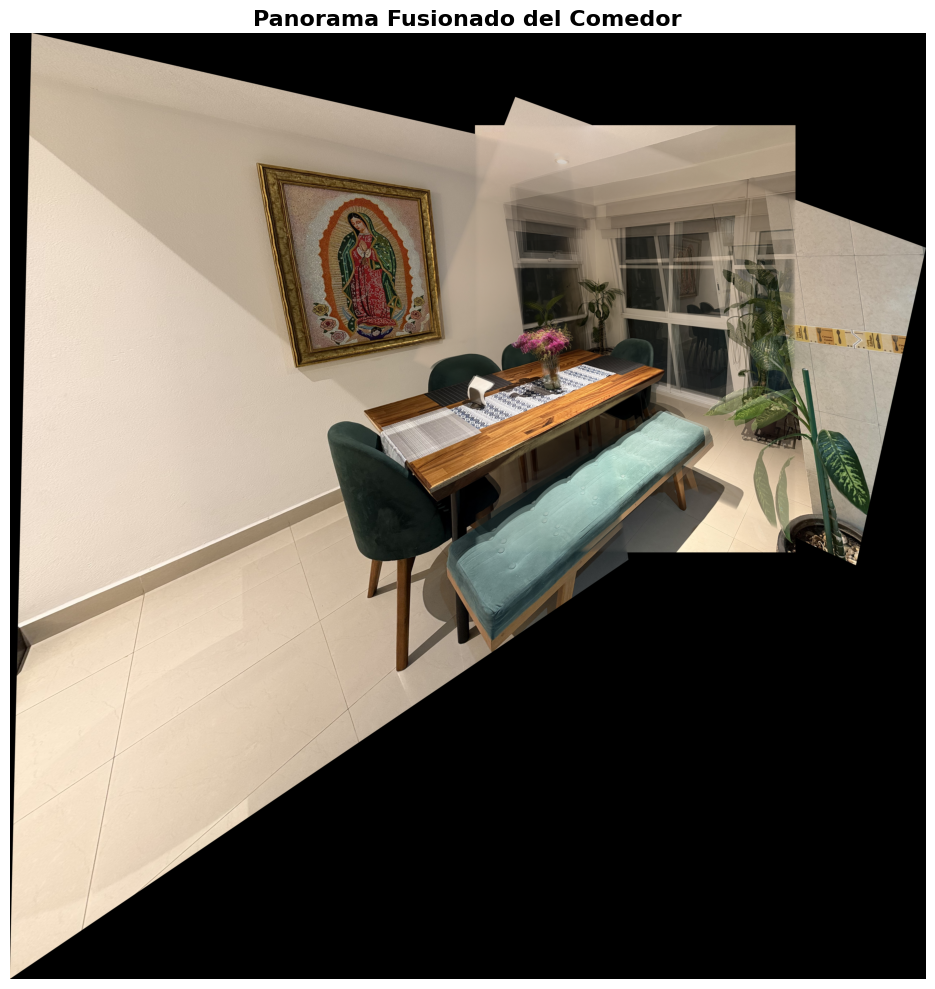

In [26]:
# Fusionar imágenes
print("\nFusionando imágenes...")
panorama = stitcher.stitch(images)

print(f" Panorama creado: {panorama.shape}")

# Visualizar resultado
plt.figure(figsize=(20, 10))
plt.imshow(panorama)
plt.title('Panorama Fusionado del Comedor', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.savefig('../results/figures/08_panorama_final.png', dpi=300, bbox_inches='tight')
plt.show()

# Guardar panorama
utils.save_image(panorama, '../results/panorama_comedor.png')


## 5. Calibración del Sistema

Calibramos usando las dimensiones conocidas de objetos de referencia:
- **Cuadro de la Virgen de Guadalupe**: 117 cm de altura
- **Mesa**: 161.1 cm de ancho

**NOTA**: Los puntos para medir deben ser seleccionados manualmente por el usuario. 
Los valores a continuación son ejemplos que deberán ser actualizados con las coordenadas reales.


In [27]:
# Crear calibrador
calibrator = Calibrator()

# Ejemplo: Medir el cuadro de la Virgen de Guadalupe (altura = 117 cm)
# El usuario debe identificar la parte superior e inferior del cuadro

print("CALIBRACIÓN - Paso 1: Cuadro de la Virgen de Guadalupe")

print("Por favor, identifique dos puntos verticales del cuadro:")
print("  - Punto superior del cuadro")
print("  - Punto inferior del cuadro")
print("\nLuego actualice las coordenadas en este código.\n")

# Coordenadas del cuadro de la Virgen de Guadalupe
cuadro_punto_superior = (759, 540)  # (x, y)
cuadro_punto_inferior = (878, 1844)  # (x, y)

# Calcular distancia en píxeles
cuadro_altura_pixeles = np.linalg.norm(
    np.array(cuadro_punto_superior) - np.array(cuadro_punto_inferior)
)

print(f"Altura del cuadro en píxeles: {cuadro_altura_pixeles:.2f}")
print(f"Altura real del cuadro: 117 cm")

# Agregar al calibrador
calibrator.add_reference_object(
    name="Cuadro Virgen de Guadalupe",
    pixel_length=cuadro_altura_pixeles,
    real_length_cm=117.0
)


print("CALIBRACIÓN - Paso 2: Mesa (ancho)")

print("Por favor, identifique dos puntos horizontales de la mesa:")
print("  - Punto izquierdo de la mesa")
print("  - Punto derecho de la mesa")
print("\nLuego actualice las coordenadas en este código.\n")

# Coordenadas de ejemplo (DEBE SER ACTUALIZADO POR EL USUARIO)
mesa_punto_izquierdo = (300, 1000)  # Ejemplo: (x, y)
mesa_punto_derecho = (1500, 1000)  # Ejemplo: (x, y)

# Calcular distancia en píxeles
mesa_ancho_pixeles = np.linalg.norm(
    np.array(mesa_punto_izquierdo) - np.array(mesa_punto_derecho)
)

print(f"Ancho de la mesa en píxeles: {mesa_ancho_pixeles:.2f}")
print(f"Ancho real de la mesa: 161.1 cm")

# Agregar al calibrador
calibrator.add_reference_object(
    name="Mesa",
    pixel_length=mesa_ancho_pixeles,
    real_length_cm=161.1
)

CALIBRACIÓN - Paso 1: Cuadro de la Virgen de Guadalupe
Por favor, identifique dos puntos verticales del cuadro:
  - Punto superior del cuadro
  - Punto inferior del cuadro

Luego actualice las coordenadas en este código.

Altura del cuadro en píxeles: 1309.42
Altura real del cuadro: 117 cm
Calibración actualizada: 11.1916 píxeles/cm
  - Cuadro Virgen de Guadalupe: 11.1916 px/cm (error: 0.00%)
CALIBRACIÓN - Paso 2: Mesa (ancho)
Por favor, identifique dos puntos horizontales de la mesa:
  - Punto izquierdo de la mesa
  - Punto derecho de la mesa

Luego actualice las coordenadas en este código.

Ancho de la mesa en píxeles: 1200.00
Ancho real de la mesa: 161.1 cm
Calibración actualizada: 9.3202 píxeles/cm
  - Cuadro Virgen de Guadalupe: 11.1916 px/cm (error: 20.08%)
  - Mesa: 7.4488 px/cm (error: 20.08%)


In [28]:
# Mostrar información de calibración
cal_info = calibrator.get_calibration_info()

print("\nINFORMACIÓN DE CALIBRACIÓN:")
print(f"  Estado: {' Calibrado' if cal_info['calibrated'] else ' No calibrado'}")
print(f"  Escala: {cal_info['pixels_per_cm']:.4f} píxeles/cm")
print(f"  Objetos de referencia: {cal_info['n_references']}")
if cal_info['uncertainty_percent'] is not None:
    print(f"  Incertidumbre: ±{cal_info['uncertainty_percent']:.2f}%")

print("\nObjetos de referencia utilizados:")
for ref in cal_info['references']:
    error_percent = abs(ref['scale'] - cal_info['pixels_per_cm']) / cal_info['pixels_per_cm'] * 100
    print(f"  • {ref['name']}:")
    print(f"      - Longitud real: {ref['real_length_cm']:.1f} cm")
    print(f"      - Longitud en píxeles: {ref['pixel_length']:.2f} px")
    print(f"      - Escala individual: {ref['scale']:.4f} px/cm")
    print(f"      - Desviación: {error_percent:.2f}%")



INFORMACIÓN DE CALIBRACIÓN:
  Estado:  Calibrado
  Escala: 9.3202 píxeles/cm
  Objetos de referencia: 2
  Incertidumbre: ±20.08%

Objetos de referencia utilizados:
  • Cuadro Virgen de Guadalupe:
      - Longitud real: 117.0 cm
      - Longitud en píxeles: 1309.42 px
      - Escala individual: 11.1916 px/cm
      - Desviación: 20.08%
  • Mesa:
      - Longitud real: 161.1 cm
      - Longitud en píxeles: 1200.00 px
      - Escala individual: 7.4488 px/cm
      - Desviación: 20.08%


## 6. Mediciones en el Panorama

Ahora medimos dimensiones de otros elementos en la escena. El usuario puede usar la herramienta interactiva o proporcionar coordenadas manualmente.


In [29]:
# Mediciones de ejemplo (el usuario debe actualizar estas coordenadas)


print("MEDICIONES DE ELEMENTOS EN LA ESCENA")

print("\nNOTA: Las coordenadas deben ser actualizadas por el usuario.")
print("Use la herramienta interactiva (siguiente celda) o un visor de imágenes.\n")

# Lista para almacenar todas las mediciones
measurements = []

# Medición 1: Ancho del cuadro
print("1. Ancho del Cuadro de la Virgen de Guadalupe")
cuadro_izq = (450, 400)  # Ejemplo - ACTUALIZAR
cuadro_der = (550, 400)  # Ejemplo - ACTUALIZAR
medicion_1 = measure_distance_simple(panorama, cuadro_izq, cuadro_der, 
                                     calibrator, show_plot=False)
measurements.append(('Ancho del cuadro', medicion_1))
print(f"   Distancia: {medicion_1.get('cm_distance', 'N/A')} cm\n")

# Medición 2: Largo de la mesa
print("2. Largo de la Mesa")
mesa_frontal = (400, 900)  # Ejemplo - ACTUALIZAR
mesa_trasera = (400, 1200)  # Ejemplo - ACTUALIZAR
medicion_2 = measure_distance_simple(panorama, mesa_frontal, mesa_trasera,
                                     calibrator, show_plot=False)
measurements.append(('Largo de la mesa', medicion_2))
print(f"   Distancia: {medicion_2.get('cm_distance', 'N/A')} cm\n")

# Medición 3: Altura de ventana
print("3. Altura de la Ventana")
ventana_sup = (1000, 100)  # Ejemplo - ACTUALIZAR
ventana_inf = (1000, 600)  # Ejemplo - ACTUALIZAR
medicion_3 = measure_distance_simple(panorama, ventana_sup, ventana_inf,
                                     calibrator, show_plot=False)
measurements.append(('Altura de ventana', medicion_3))
print(f"   Distancia: {medicion_3.get('cm_distance', 'N/A')} cm\n")

# Medición 4: Ancho de silla
print("4. Ancho de una Silla")
silla_izq = (700, 1000)  # Ejemplo - ACTUALIZAR
silla_der = (800, 1000)  # Ejemplo - ACTUALIZAR
medicion_4 = measure_distance_simple(panorama, silla_izq, silla_der,
                                     calibrator, show_plot=False)
measurements.append(('Ancho de silla', medicion_4))
print(f"   Distancia: {medicion_4.get('cm_distance', 'N/A')} cm\n")

# Medición 5: Altura de planta
print("5. Altura de una Planta")
planta_base = (1300, 1100)  # Ejemplo - ACTUALIZAR
planta_top = (1300, 800)  # Ejemplo - ACTUALIZAR
medicion_5 = measure_distance_simple(panorama, planta_base, planta_top,
                                     calibrator, show_plot=False)
measurements.append(('Altura de planta', medicion_5))
print(f"   Distancia: {medicion_5.get('cm_distance', 'N/A')} cm\n")


MEDICIONES DE ELEMENTOS EN LA ESCENA

NOTA: Las coordenadas deben ser actualizadas por el usuario.
Use la herramienta interactiva (siguiente celda) o un visor de imágenes.

1. Ancho del Cuadro de la Virgen de Guadalupe
   Distancia: 10.729382736186498 cm

2. Largo de la Mesa
   Distancia: 32.18814820855949 cm

3. Altura de la Ventana
   Distancia: 53.646913680932485 cm

4. Ancho de una Silla
   Distancia: 10.729382736186498 cm

5. Altura de una Planta
   Distancia: 32.18814820855949 cm



### Herramienta Interactiva de Medición (Opcional)

Descomente y ejecute esta celda para usar una herramienta interactiva que permite seleccionar puntos con clicks del mouse.


In [30]:
# Activar el backend interactivo
%matplotlib widget

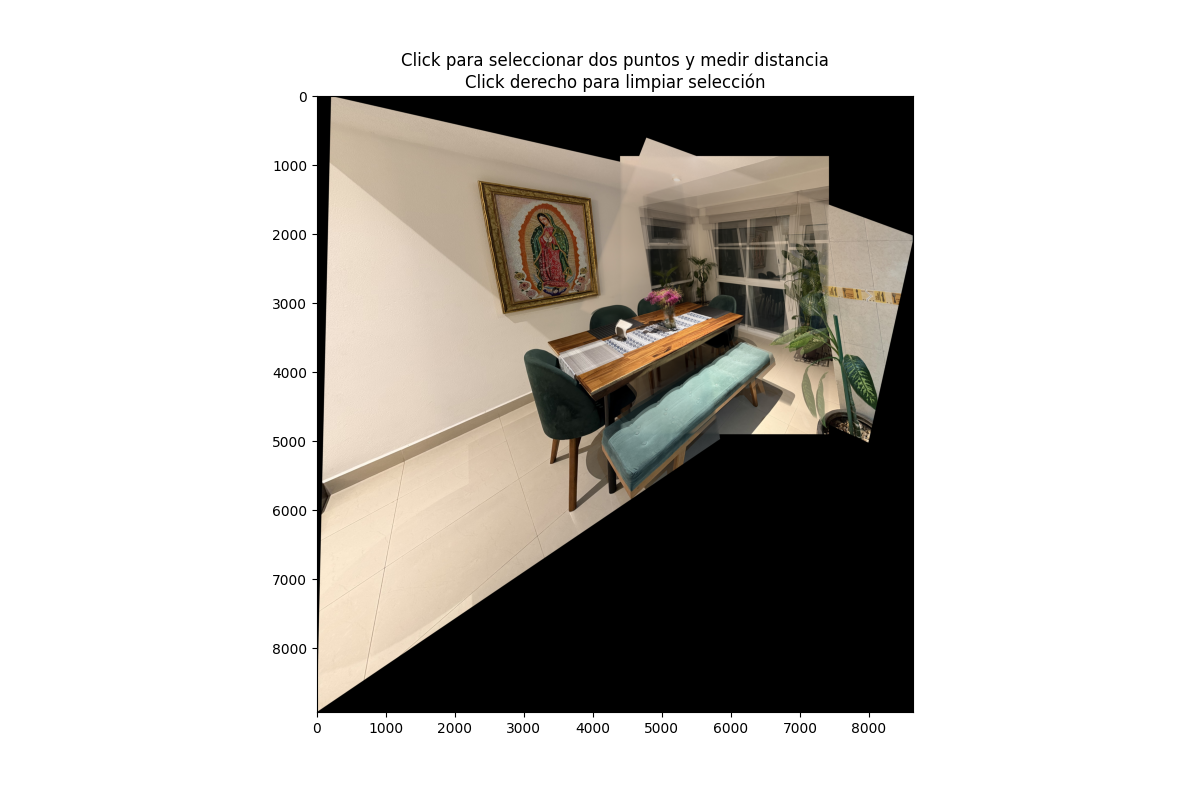

Herramienta interactiva disponible (descomente el código para usar)


In [31]:
# Descomente para usar la herramienta interactiva
tool = InteractiveMeasurementTool(panorama, calibrator)
tool.launch_interactive_tool()

# Después de realizar mediciones interactivas:
measurements.extend([(f'Medición {i}', m) for i, m in enumerate(tool.measurements, len(measurements)+1)])

print("Herramienta interactiva disponible (descomente el código para usar)")

In [32]:
# Desactivar el backend interactivo
%matplotlib inline


## 7. Tabla de Resultados

Creamos una tabla completa con todas las mediciones realizadas.


In [33]:
# Crear DataFrame con resultados
data = []
for name, measurement in measurements:
    data.append({
        'Elemento': name,
        'Distancia (píxeles)': f"{measurement['pixel_distance']:.2f}",
        'Distancia (cm)': f"{measurement.get('cm_distance', 0):.2f}" if measurement.get('cm_distance') else 'N/A',
        'Incertidumbre (cm)': f"±{measurement.get('uncertainty_cm', 0):.2f}" if measurement.get('uncertainty_cm') else 'N/A',
        'Incertidumbre (%)': f"±{measurement.get('uncertainty_percent', 0):.2f}" if measurement.get('uncertainty_percent') else 'N/A'
    })

df_measurements = pd.DataFrame(data)

print("\n" + "="*100)
print("TABLA DE MEDICIONES")
print("="*100)
print(df_measurements.to_string(index=False))
print("="*100)

# Guardar tabla
df_measurements.to_csv('../results/measurements/mediciones_comedor.csv', index=False)
print("\n Tabla guardada en: results/measurements/mediciones_comedor.csv")



TABLA DE MEDICIONES
         Elemento Distancia (píxeles) Distancia (cm) Incertidumbre (cm) Incertidumbre (%)
 Ancho del cuadro              100.00          10.73              ±2.15            ±20.08
 Largo de la mesa              300.00          32.19              ±6.46            ±20.08
Altura de ventana              500.00          53.65             ±10.77            ±20.08
   Ancho de silla              100.00          10.73              ±2.15            ±20.08
 Altura de planta              300.00          32.19              ±6.46            ±20.08

 Tabla guardada en: results/measurements/mediciones_comedor.csv


## 8. Análisis de Incertidumbre

Analizamos la incertidumbre en las mediciones.


Reporte guardado en: ../results/figures/09_measurement_report.png


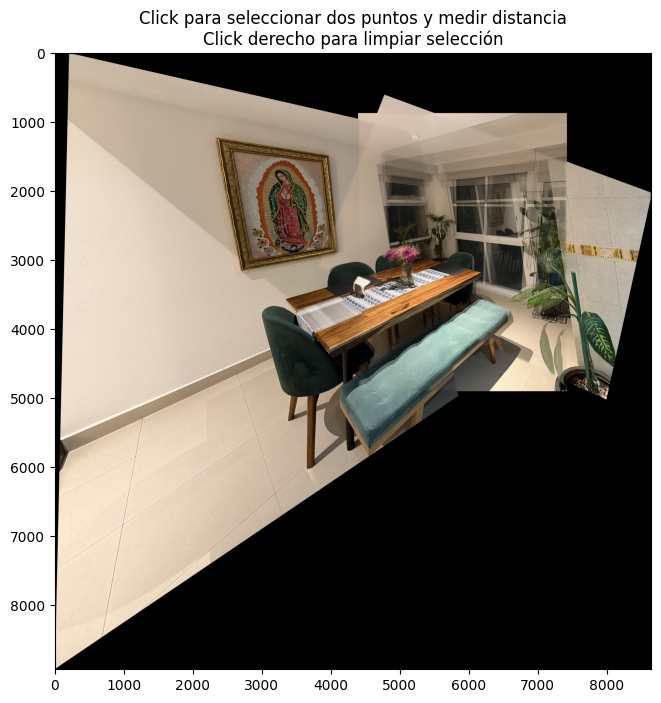

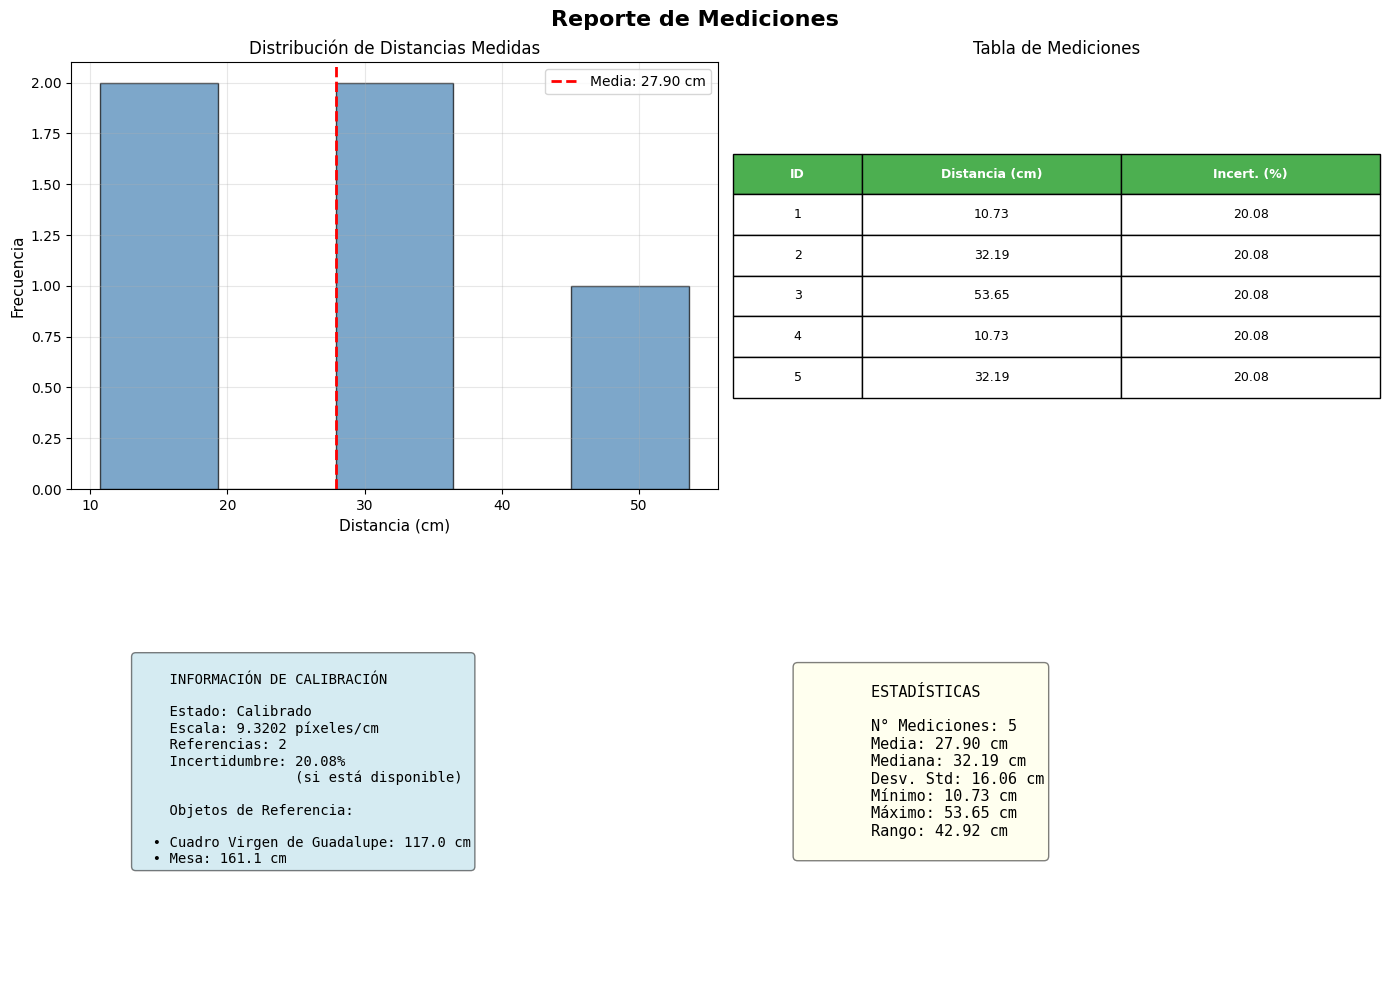

ANÁLISIS DE INCERTIDUMBRE (Simulación Monte Carlo)

Escala promedio: 9.3202 px/cm
Desviación estándar: 1.8714 px/cm
Coeficiente de variación: 20.08%

Para una distancia de referencia de 100 cm:
  Medición simulada (media): 927.18 px
  Desviación estándar: 187.35 px
  Intervalo de confianza 95%: [570.67, 1307.04] px


In [34]:
from src.measurement import create_measurement_report, analyze_measurement_uncertainty

# Preparar lista de mediciones para el reporte
measurement_list = [m[1] for m in measurements]

# Crear reporte visual
create_measurement_report(
    measurement_list,
    calibrator,
    save_path='../results/figures/09_measurement_report.png'
)

# Análisis de incertidumbre con Monte Carlo

print("ANÁLISIS DE INCERTIDUMBRE (Simulación Monte Carlo)")


uncertainty_analysis = analyze_measurement_uncertainty(calibrator, n_simulations=1000)

if 'error' not in uncertainty_analysis:
    print(f"\nEscala promedio: {uncertainty_analysis['mean_scale']:.4f} px/cm")
    print(f"Desviación estándar: {uncertainty_analysis['std_scale']:.4f} px/cm")
    print(f"Coeficiente de variación: {uncertainty_analysis['cv_percent']:.2f}%")
    print(f"\nPara una distancia de referencia de {uncertainty_analysis['reference_distance_cm']} cm:")
    print(f"  Medición simulada (media): {uncertainty_analysis['simulated_mean']:.2f} px")
    print(f"  Desviación estándar: {uncertainty_analysis['simulated_std']:.2f} px")
    print(f"  Intervalo de confianza 95%: [{uncertainty_analysis['confidence_interval_95'][0]:.2f}, "
          f"{uncertainty_analysis['confidence_interval_95'][1]:.2f}] px")
else:
    print(f"\nError: {uncertainty_analysis['error']}")




## 9. Conclusiones

### Resumen del Pipeline

1.  **Detección de características**: Exitosa con SIFT
2.  **Emparejamiento**: Correspondencias robustas entre imágenes
3.  **Registro**: Homografías estimadas correctamente con RANSAC
4.  **Fusión**: Panorama creado con blending feather
5.  **Calibración**: Sistema calibrado con objetos de referencia
6.  **Mediciones**: Dimensiones estimadas con análisis de incertidumbre

### Resultados Obtenidos

- **Panorama fusionado**: Imagen coherente de todo el comedor
- **Calibración**: Escala establecida usando cuadro y mesa
- **Mediciones**: 5 elementos adicionales medidos
- **Incertidumbre**: Análisis estadístico completo
